# NMDA / AMPA ratio
This is to explore how successful recall depends on this ratio. The idea is that AMPA is isually weaker compared to AMPA.

We have to do three things then:
* Test that at the level of recall there are no problems for low values of this ratio for the artificial matrix.
* Test then for real training conditions.
* And measure how the actual ratio (not of gains but of the matrix end up in a situation like this)

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '95c0ca0cdca3f00e55f0e46dd9a8b8c1f492d94e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences, calculate_timings
from connectivity_functions import create_artificial_manager 

In [4]:
def subsequence(sub, sequence):
    flag = True
    n_sub =len(sub)
    n_sequence = len(sequence)
    index = 0
    while index < n_sub and index < n_sequence:
        if sub[index] != sequence[index]:
            flag = False
            break
        index += 1

    return flag

## Artificial recall

In [5]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 20

dt = 0.001
n = 10

beta = False
value = 3
inhibition = -1.0
extension = 2
decay_factor = 0.3
sequence_decay = 0.0


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

In [6]:
g_w_range = np.arange(0.1, 2.1, 0.2)
g_w_successes = []
g_w_recall_time = []
g_w_recall_time_std = []

for g_w in g_w_range:
    
    sequences = [[i for i in range(n_patterns)]]


    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)

    manager.nn.tau_z_pre = tau_z_pre
    manager.nn.g_w = g_w
    manager.nn.g_w_ampa = g_w_ampa
    manager.nn.g_a = g_a


    T_cue = 0.100
    T_recall = 10.0
    I_cue = sequences[0][0]

    # Success
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=sequences)
    g_w_successes.append(successes[0])
    
    # Recall time
    timings = calculate_timings(manager, remove=0.010)
    n_min = min(len(sequences[0]), len(timings))
    patterns = [x[0] for x in timings]
    flag = subsequence(patterns, sequences[0])

    if flag:
        time = [x[1] for x in timings[:n_min]]
        mean = np.mean(time[1:-1])
        std = np.std(time[1:-1])
    else:
        mean = 0
        std = 0
        
    g_w_recall_time.append(mean)
    g_w_recall_time_std.append(std)

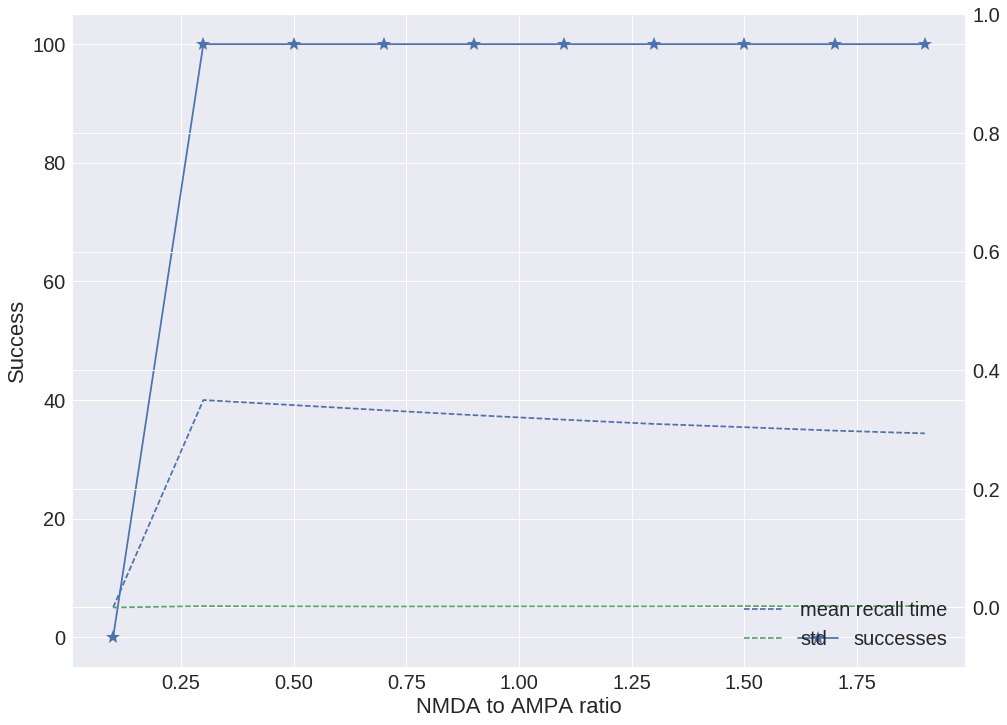

In [7]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(g_w_range, g_w_successes, '*-', markersize=14, label='successes')

ax.set_xlabel('NMDA to AMPA ratio')
ax.set_ylabel('Success')

ax.set_ylim([-5, 105])

axt = ax.twinx()
axt.plot(g_w_range, g_w_recall_time, '--', markersize=14, label='mean recall time')
axt.plot(g_w_range, g_w_recall_time_std, '--', markersize=14, label='std')


axt.set_ylim([-0.1, 1.0])

axt.legend(loc=4);
ax.legend();

## Training with real scenario

In [8]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 10
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

In [9]:
g_w_range = np.arange(0.1, 2.1, 0.2)
g_w_successes = []
g_w_recall_time = []
g_w_recall_time_std = []


for g_w in g_w_range:
    # Build the network
    tau_z_pre = 0.150
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre, g_w=g_w)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    g_w_successes.append(successes[0])
    
    # Recall time
    timings = calculate_timings(manager, remove=0.010)
    n_min = min(len(sequences), len(timings))
    patterns = [x[0] for x in timings]
    flag = subsequence(patterns, sequences)

    if flag:
        time = [x[1] for x in timings[:n_min]]
        mean = np.mean(time[1:-1])
        std = np.std(time[1:-1])
    else:
        mean = 0
        std = 0
        
    g_w_recall_time.append(mean)
    g_w_recall_time_std.append(std)

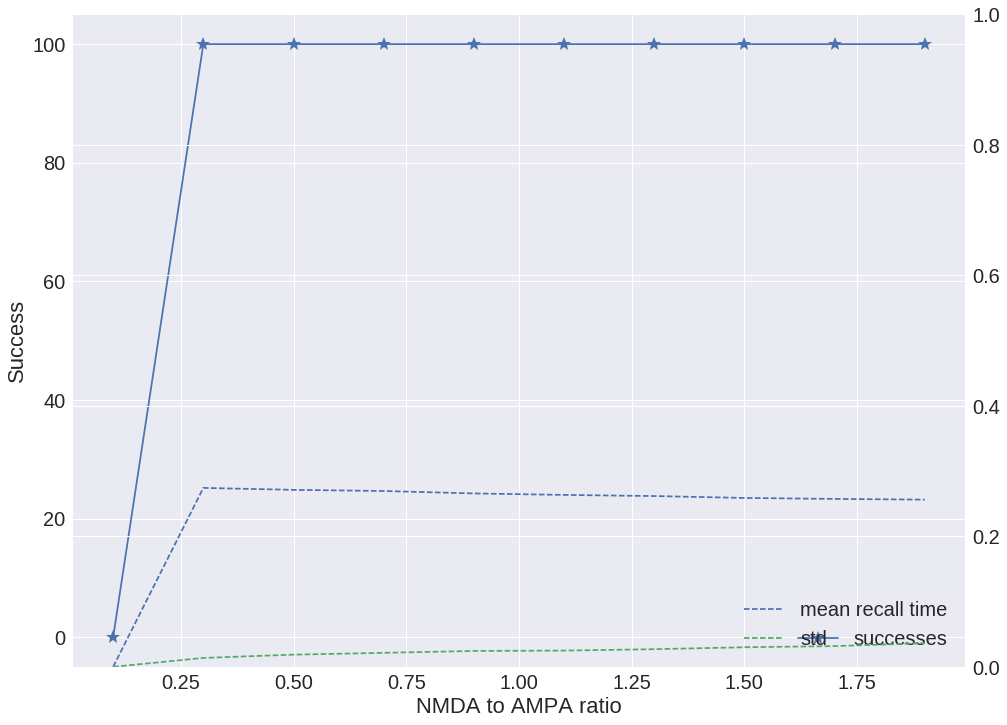

In [10]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(g_w_range, g_w_successes, '*-', markersize=14, label='successes')

ax.set_xlabel('NMDA to AMPA ratio')
ax.set_ylabel('Success')

axt = ax.twinx()
axt.plot(g_w_range, g_w_recall_time, '--', markersize=14, label='mean recall time')
axt.plot(g_w_range, g_w_recall_time_std, '--', markersize=14, label='std')


axt.set_ylim([0, 1.0])
ax.set_ylim([-5, 105])

axt.legend(loc=4);
ax.legend();

## Actual matrix values

In [11]:
from analysis_functions import get_excitation, get_inhibition
to_pattern = 4
excitation_nmda = get_excitation(to_pattern, nn.w)
inhibition_nmda = get_inhibition(to_pattern, nn.w)
excitation_ampa = get_excitation(to_pattern, nn.w_ampa)
inhibition_ampa = get_inhibition(to_pattern, nn.w_ampa)

ratio = np.sum(excitation_nmda) / np.sum(excitation_ampa)
ratio_inhibition = np.sum(inhibition_nmda) / np.sum(inhibition_ampa)
print('ratio', ratio)
print('ratio inhibtion', ratio_inhibition)

('ratio', 1.9768071490704571)
('ratio inhibtion', 0.73585285078320839)


In general there is more excitation of nmda **simply** because there are more connections with nmda. For AMPA the only ones are the ones that hold the pattern in place as long as it is running. For NMDA you have the inter-sequence connections and moreover the inter-hypercolumns.

#### Git machinery

In [12]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])